##### Figure 3: Vgsc PCA

In [1]:
from collections import defaultdict
import dask.array as da
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as tkr
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import re

import allel

import ingenos

In [2]:
base_path = "/overflow/dschridelab/users/rrlove/aedes/"
md_path = f"{base_path}metadata/"
results_path = f"{base_path}results/"
zarr_path = "/proj/dschridelab/rrlove/aedes/vcf/filtered_110122/"

In [3]:
def return_data(zarr_path, data_type, data_name):
    
    fetch_str = f"{data_type}/{data_name}" 
    
    return da.from_zarr(zarr_path, component=fetch_str)

In [4]:
chroms = ["AaegL5_1", "AaegL5_2", "AaegL5_3"]
countries = ["Brazil", "Colombia", "USA", "Gabon", "Kenya", "Senegal"]

##### read in the data for AaegL5_3, and the metadata

In [5]:
chroms_dict = defaultdict(dict)

chroms = ["AaegL5_3"]

for chrom in chroms:
    
    temp_in_path = zarr_path + chrom

    chroms_dict[chrom]["pos"] = return_data(temp_in_path, "variants", "POS")
    chroms_dict[chrom]["chrom"] = return_data(temp_in_path, "variants", "CHROM")
    chroms_dict[chrom]["ref"] = return_data(temp_in_path, "variants", "REF")
    chroms_dict[chrom]["alt"] = return_data(temp_in_path, "variants", "ALT")
    chroms_dict[chrom]["ac"] = return_data(temp_in_path, "variants", "AC")
    chroms_dict[chrom]["qd"] = return_data(temp_in_path, "variants", "QD")
    chroms_dict[chrom]["mq"] = return_data(temp_in_path, "variants", "MQ")
    chroms_dict[chrom]["fs"] = return_data(temp_in_path, "variants", "FS")
    chroms_dict[chrom]["mqrs"] = return_data(temp_in_path, "variants", "MQRankSum")
    chroms_dict[chrom]["rprs"] = return_data(temp_in_path, "variants", "ReadPosRankSum")
    chroms_dict[chrom]["sor"] = return_data(temp_in_path, "variants", "SOR")
    chroms_dict[chrom]["is_snp"] = return_data(temp_in_path, "variants", "is_snp")
    chroms_dict[chrom]["numalt"] = return_data(temp_in_path, "variants", "numalt")
    chroms_dict[chrom]["filter_pass"] = return_data(temp_in_path, "variants", "FILTER_PASS")

    chroms_dict[chrom]["gt"] = return_data(temp_in_path, "calldata", "GT")
    chroms_dict[chrom]["gq"] = return_data(temp_in_path, "calldata", "GQ")
    chroms_dict[chrom]["ad"] = return_data(temp_in_path, "calldata", "AD")
    chroms_dict[chrom]["pl"] = return_data(temp_in_path, "calldata", "PL")
    chroms_dict[chrom]["dp"] = return_data(temp_in_path, "calldata", "DP")
    
    print(chrom, chroms_dict[chrom]["gt"].shape)
    
samples = da.from_zarr(temp_in_path, component="samples")

AaegL5_3 (27660249, 131, 2)


In [6]:
md = pd.read_table(
    md_path + "whole_sample_sorted_country.031522.csv", 
    sep="\t",)

md["locality"] = md["location"].str.split(": ", expand=True)[1]

md.head()

,sample_id,sample_short,location,sex,batch,sample_id_cat,country,locality
0,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,FEMALE_1,Colombia: Rio Claro,F,1,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,Colombia,Rio Claro
1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,FEMALE_10,Colombia: Rio Claro,F,1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,Colombia,Rio Claro
2,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,FEMALE_11,Colombia: Rio Claro,F,1,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,Colombia,Rio Claro
3,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,FEMALE_12,Colombia: Rio Claro,F,1,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,Colombia,Rio Claro
4,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,FEMALE_14,Colombia: Rio Claro,F,1,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,Colombia,Rio Claro


In [7]:
np.sum(~(md["sample_id"] == samples.compute()))

0

##### remove closely-related specimens

In [8]:
to_drop = np.loadtxt(md_path + "close_kin_removed_new_dataset.txt",
                    dtype=str)

to_drop_bool = (~(md["sample_short"].isin(to_drop)).values)

np.sum(to_drop_bool)

123

In [9]:
md_filtered = md.loc[to_drop_bool]

md_filtered.shape

(123, 8)

##### read in the genes

In [10]:
gff3 = pd.read_table("/overflow/dschridelab/users/rrlove/aedes/refs/aegy/VectorBase-54_AaegyptiLVP_AGWG.gff",
                     sep="\t", comment="#", header=None)

gff3.columns = ["seqid", "source", "type", "start", "end", "score", "strand",
               "phase", "attributes"]

gff3["name"] = gff3["attributes"].str.split(";", expand=True)[0].str.lstrip("ID=")

genes = gff3.loc[gff3["type"] == "protein_coding_gene"]

genes.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name
0,AaegL5_3,VEuPathDB,protein_coding_gene,157422094,157471671,.,-,.,ID=AAEL010223;description=phosphatidylserine d...,AAEL010223
67,AaegL5_2,VEuPathDB,protein_coding_gene,65150768,65155203,.,-,.,ID=AAEL013940;description=chromatin assembly f...,AAEL013940
79,AaegL5_2,VEuPathDB,protein_coding_gene,303181186,303183527,.,+,.,ID=AAEL002384;description=unspecified product,AAEL002384
89,AaegL5_1,VEuPathDB,protein_coding_gene,247947181,247966533,.,-,.,ID=AAEL003769;description=Methionine aminopept...,AAEL003769
105,AaegL5_3,VEuPathDB,protein_coding_gene,368609784,368611605,.,+,.,ID=AAEL014609;Name=CYP9J26;description=cytochr...,AAEL014609


In [11]:
genes_1 = genes.loc[genes["seqid"] == "AaegL5_1"]
genes_2 = genes.loc[genes["seqid"] == "AaegL5_2"]
genes_3 = genes.loc[genes["seqid"] == "AaegL5_3"]

##### extract exons for Vgsc (AAEL023266)

In [12]:
exons = gff3[((gff3["attributes"].str.contains("AAEL023266")) &\
              (gff3["type"] == "exon"))]

exons.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name
211177,AaegL5_3,VEuPathDB,exon,315926360,315931874,.,-,.,ID=exon_AAEL023266-RA-E37;Parent=AAEL023266-RA...,exon_AAEL023266-RA-E37
211178,AaegL5_3,VEuPathDB,exon,315931941,315932245,.,-,.,ID=exon_AAEL023266-RA-E36;Parent=AAEL023266-RA...,exon_AAEL023266-RA-E36
211179,AaegL5_3,VEuPathDB,exon,315938708,315938978,.,-,.,ID=exon_AAEL023266-RA-E35;Parent=AAEL023266-RA...,exon_AAEL023266-RA-E35
211180,AaegL5_3,VEuPathDB,exon,315939046,315939291,.,-,.,ID=exon_AAEL023266-RA-E34;Parent=AAEL023266-RA...,exon_AAEL023266-RA-E34
211181,AaegL5_3,VEuPathDB,exon,315939361,315939555,.,-,.,ID=exon_AAEL023266-RA-E33;Parent=AAEL023266-RA...,exon_AAEL023266-RA-E33


##### plot PCA, loadings, and exons

In [13]:
#from https://stackoverflow.com/questions/27575257/how-to-divide-y-ticks-by-a-certain-number-in-matplotlib

def numfmt(x, pos):
    s = '{}'.format((x / 1000000))
    return s

yfmt = tkr.FuncFormatter(numfmt)

In [14]:
outString = ingenos.make_date_stamp(results_path + \
                                    "popgen/Vgsc_PCA_with_labels", 
                                    ".pdf")

outString

'/overflow/dschridelab/users/rrlove/aedes/results/popgen/Vgsc_PCA_with_labels.021023.pdf'

In [15]:
vgsc_flt = ((chroms_dict[chrom]["pos"] > 315926360) &\
            (chroms_dict[chrom]["pos"] < 316405639))

np.sum(vgsc_flt).compute()

33298

In [16]:
gt_chunk = allel.GenotypeArray(
    chroms_dict[chrom]["gt"]).subset(sel0 = vgsc_flt, sel1 = to_drop_bool)

gt_chunk.shape

(33298, 123, 2)

In [17]:
pos = chroms_dict[chrom]["pos"]

vgsc_pos = allel.SortedIndex(pos[vgsc_flt])

vgsc_pos

0,1,2,3,4,...,33293,33294,33295,33296,33297
315926367,315926376,315926377,315926384,315926386,...,316405534,316405546,316405562,316405564,316405604


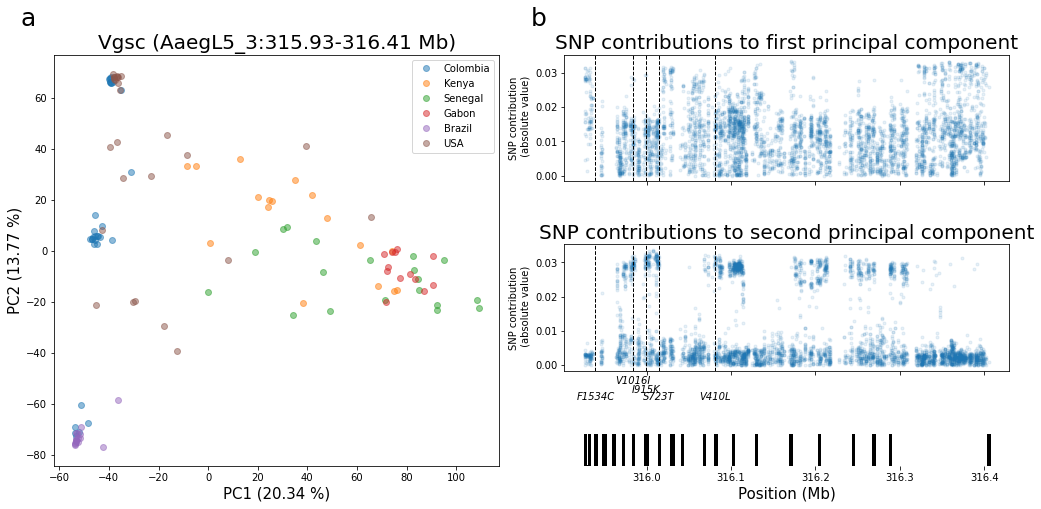

In [18]:
fig = plt.figure(figsize=(14, 7), constrained_layout=True)

gs = GridSpec(5, 2, figure=fig)

##calculate and plot PCA
ax1 = fig.add_subplot(gs[:, 0])

allele_counts = allel.AlleleCountsArray(
    gt_chunk.count_alleles())

allele_counts_boolean = (allele_counts.max_allele() <= 2) &\
(allele_counts[:, :2].min(axis=1) > 1) & (
    allele_counts.to_frequencies()[:,1] > 0.05)

n_alts = gt_chunk\
.subset(sel0 = allele_counts_boolean).to_n_alt()
    
coords, model = allel.pca(n_alts)

x = coords[:, 0]
y = coords[:, 1]

for country in md_filtered["country"].unique():
    
    flt = md_filtered["country"] == country

    ax1.plot(x[flt], y[flt], linestyle = ' ', marker = "o", label=country,
           alpha = 0.5)

ax1.set_xlabel(f"PC1 ({round(model.explained_variance_ratio_[0]*100, 2)} %)", 
               fontsize=15)
ax1.set_ylabel(f"PC2 ({round(model.explained_variance_ratio_[1]*100, 2)} %)", 
               fontsize=15)

ax1.set_title("Vgsc (AaegL5_3:315.93-316.41 Mb)", fontsize=20)

ax1.legend()

##plot loadings
ax2 = fig.add_subplot(gs[:2, 1])
ax3 = fig.add_subplot(gs[2:4, 1], sharex = ax2)
ax4 = fig.add_subplot(gs[4, 1], sharex = ax3)

ax2.plot(pos[vgsc_flt.compute()][allele_counts_boolean], 
         abs(model.components_[0]), 
        marker=".", linestyle = " ", alpha = 0.1)

ax2.set_ylabel("SNP contribution\n (absolute value)")
ax2.set_title("SNP contributions to first principal component", fontsize=20);

ax3.plot(pos[vgsc_flt.compute()][allele_counts_boolean], 
         abs(model.components_[1]), 
        marker=".", linestyle = " ", alpha = 0.1)

ax3.set_ylabel("SNP contribution\n (absolute value)")
ax3.set_title("SNP contributions to second principal component", fontsize=20);

##show locations of exons
for i, row in exons.iterrows():
    
    exon_length = row["end"] - row["start"]
    
    rect = patches.Rectangle((row["start"], 0), exon_length, 10, linewidth=3,
                            edgecolor = "black", facecolor = "none")
    
    ax4.add_patch(rect)

##show locations of focal SNPs: 
#positions corresponding to F1534C, V1016I, I915K, S723T, V410L
trans = transforms.blended_transform_factory(ax3.transData, ax3.transAxes)

snps = [315939224, 315983763, 315999297, 316014588, 316080722]
for snp, label, y_place in zip(snps,
                               ["F1534C", "V1016I", "I915K", "S723T", "V410L"],
                               [-.23, -.1,-.17,-.23,-.23]):
    
    ax2.axvline(x=snp, color="black", linestyle="--", linewidth=1)
    ax3.axvline(x=snp, color="black", linestyle="--", linewidth=1)
    ax4.axvline(x=snp, color="black", linestyle="--", linewidth=1)
    
    ax3.text(x=snp, y=y_place, s=label, fontstyle="italic", ha="center",
             transform=trans)
    
##formatting    
ax2.tick_params(labelbottom=False)
ax3.tick_params(labelbottom=False)
    
ax4.set_xlabel("Position (Mb)", fontsize=15)
ax4.ticklabel_format(style='plain')
ax4.xaxis.set_major_formatter(yfmt)

ax4.get_yaxis().set_visible(False)
for spine in ax4.spines.values():
    
    spine.set_visible(False)
        
##add panel labels
for i, ax in enumerate([ax1, ax2]):

    trans = \
    transforms.blended_transform_factory(
        ax.transAxes, fig.transFigure)

    label = ["a","b"][i]
    ax.text(x=-0.075, y=0.95, s=label, transform=trans, 
            fontsize=25)

#plt.savefig(outString, bbox_inches="tight")

##### Figure S14: PCA based on bcftools mpileup genotypes

##### read in the file

In [19]:
vcf = allel.read_vcf(
    "/proj/dschridelab/rrlove/aedes/vcf/Vssc/AaegL5_3_Vssc_mpileup.vcf.gz", 
    fields=["*"])

/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/allel/io/vcf_read.py:1732: UserWarning: invalid INFO header: '##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">\n'
  warnings.warn('invalid INFO header: %r' % header)


##### reorder the metadata so the sample order matches that found in the vcf

In [20]:
md_vcf = md.copy()

md_vcf.head()

,sample_id,sample_short,location,sex,batch,sample_id_cat,country,locality
0,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,FEMALE_1,Colombia: Rio Claro,F,1,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,Colombia,Rio Claro
1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,FEMALE_10,Colombia: Rio Claro,F,1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,Colombia,Rio Claro
2,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,FEMALE_11,Colombia: Rio Claro,F,1,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,Colombia,Rio Claro
3,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,FEMALE_12,Colombia: Rio Claro,F,1,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,Colombia,Rio Claro
4,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,FEMALE_14,Colombia: Rio Claro,F,1,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,Colombia,Rio Claro


In [21]:
len(md_vcf)

131

In [22]:
md_vcf["sample_id_cat"] = md_vcf["sample_id"].astype("category")

md_vcf["sample_id_cat"].cat.set_categories(pd.Series(vcf["samples"]), 
                                   inplace=True)

md_vcf.sort_values("sample_id_cat", inplace=True)

md_vcf.head()

,sample_id,sample_short,location,sex,batch,sample_id_cat,country,locality
96,SRR11006847,SRR11006847,Brazil: Santarem,NaN,PRJNA602495,SRR11006847,Brazil,Santarem
82,SRR11006830,SRR11006830,Gabon: Franceville,NaN,PRJNA602495,SRR11006830,Gabon,Franceville
35,SRR11006666,SRR11006666,Kenya: KayaBomu,NaN,PRJNA602495,SRR11006666,Kenya,KayaBomu
76,SRR11006824,SRR11006824,Gabon: Franceville,NaN,PRJNA602495,SRR11006824,Gabon,Franceville
80,SRR11006828,SRR11006828,Gabon: Franceville,NaN,PRJNA602495,SRR11006828,Gabon,Franceville


In [23]:
np.sum(~(md_vcf["sample_id"] == vcf["samples"]))

0

In [24]:
vcf_bool = (~(md_vcf["sample_short"].isin(to_drop))).values

np.sum(vcf_bool)

123

In [25]:
md_vcf_filtered = md_vcf[vcf_bool]

len(md_vcf_filtered)

123

In [26]:
vcf_pos = allel.SortedIndex(vcf["variants/POS"][vcf["variants/is_snp"]])

len(vcf_pos)

347281

In [27]:
vcf_gt_1 = allel.GenotypeArray(vcf["calldata/GT"][vcf["variants/is_snp"]]).subset(
    sel1 = vcf_bool)

vcf_gt_2 = allel.GenotypeArray(vcf["calldata/GT"][vcf["variants/is_snp"]]).subset(
    sel1 = vcf_bool)

vcf_gt_1.shape, vcf_gt_2.shape

((347281, 123, 2), (347281, 123, 2))

In [28]:
np.sum(vcf_gt_1.is_called()), np.sum(vcf_gt_2.is_called())

(36391580, 36391580)

In [29]:
vcf_gq = vcf["calldata/GQ"][vcf["variants/is_snp"]][:, vcf_bool]

vcf_gq.shape

(347281, 123)

In [30]:
vgsc_coords = (315926360, 316405639)

region_flt = ((vcf_pos > vgsc_coords[0]) & \
            (vcf_pos < vgsc_coords[1]))

np.sum(region_flt)

96347

In [31]:
vcf_gt_2.mask = vcf_gq < 20

np.sum(vcf_gt_2.is_called())

30851386

In [32]:
outString = ingenos.make_date_stamp(results_path + \
                                    "Vssc/Vgsc_only_mpileup_PCAs_new_dataset_no_relatives", ".pdf")

outString

'/overflow/dschridelab/users/rrlove/aedes/results/Vssc/Vgsc_only_mpileup_PCAs_new_dataset_no_relatives.021023.pdf'

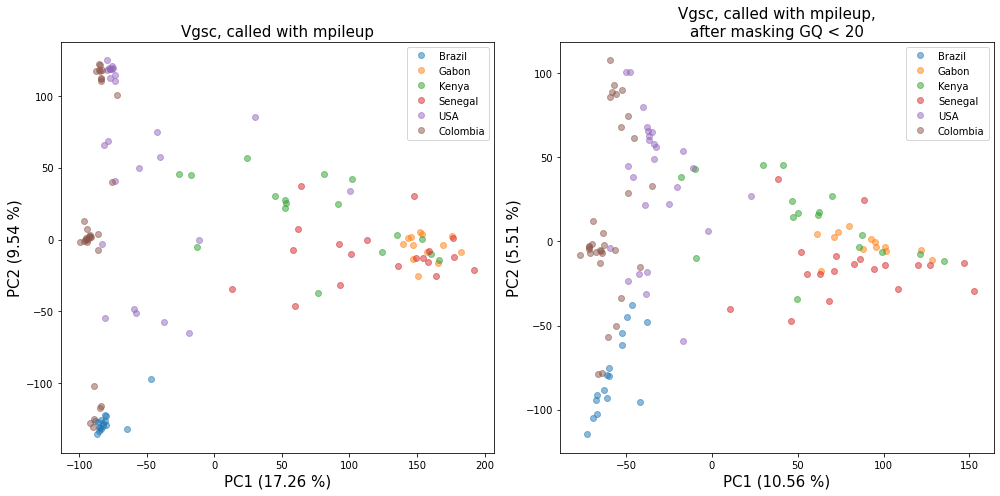

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 7))

##Vgsc without masking

ax = axes[0]

allele_counts = allel.AlleleCountsArray(vcf_gt_1.subset(sel0 = region_flt).count_alleles())

allele_counts_boolean = (allele_counts.max_allele() <= 2) &\
(allele_counts[:, :2].min(axis=1) > 1) & (
    allele_counts.to_frequencies()[:,1] > 0.05)

n_alts = vcf_gt_1.subset(sel0 = region_flt).subset(sel0 = allele_counts_boolean).to_n_alt()

coords, model = allel.pca(n_alts)

x = coords[:, 0]
y = coords[:, 1]

for country in md_vcf_filtered["country"].unique():

    flt = md_vcf_filtered["country"] == country

    ax.plot(x[flt], y[flt], linestyle = ' ', marker = "o", label=country,
           alpha = 0.5)

ax.set_xlabel(f"PC1 ({round(model.explained_variance_ratio_[0]*100, 2)} %)", fontsize=15)
ax.set_ylabel(f"PC2 ({round(model.explained_variance_ratio_[1]*100, 2)} %)", fontsize=15)

ax.set_title("Vgsc, called with mpileup", fontsize=15)

ax.legend()

##Vgsc with masking

ax = axes[1]

allele_counts = allel.AlleleCountsArray(vcf_gt_2.subset(sel0 = region_flt).count_alleles())

allele_counts_boolean = (allele_counts.max_allele() <= 2) &\
(allele_counts[:, :2].min(axis=1) > 1) & (
    allele_counts.to_frequencies()[:,1] > 0.05)

n_alts = vcf_gt_2.subset(sel0 = region_flt).subset(sel0 = allele_counts_boolean).to_n_alt()

coords, model = allel.pca(n_alts)

x = coords[:, 0]
y = coords[:, 1]

for country in md_vcf_filtered["country"].unique():

    flt = md_vcf_filtered["country"] == country

    ax.plot(x[flt], y[flt], linestyle = ' ', marker = "o", label=country,
           alpha = 0.5)

ax.set_xlabel(f"PC1 ({round(model.explained_variance_ratio_[0]*100, 2)} %)", fontsize=15)
ax.set_ylabel(f"PC2 ({round(model.explained_variance_ratio_[1]*100, 2)} %)", fontsize=15)

ax.set_title("Vgsc, called with mpileup,\nafter masking GQ < 20", fontsize=15)

ax.legend()

plt.tight_layout()

#plt.savefig(outString, bbox_inches="tight")